In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# **ESTADÍSTICAS**

In [ ]:
lye

,Departamento,Sabe Leer y Escribir,No Sabe Leer y Escribir,Total,Poblacion,Sabe Leer y Escribir %,No Sabe Leer y Escribir %
Microrregion,,,,,,,
Sur,Apóstoles,13235,1235,14470,42249,31.33,2.92
Centro,Cainguás,17038,1943,18981,53403,31.90,3.64
Sur,Candelaria,8440,906,9346,27040,31.21,3.35
Sur,Capital,90497,7243,97740,324756,27.87,2.23
Sur,Concepción,3121,300,3421,9577,32.59,3.13
Alto Parana,Eldorado,23134,2226,25360,78581,29.44,2.83
Nordeste,General Manuel Belgrano,14235,1959,16194,42902,33.18,4.57
Alto Uruguay,Guaraní,21875,3152,25027,67897,32.22,4.64
Alto Parana,Iguazú,24860,2597,27457,82227,30.23,3.16


In [ ]:
analisis1 = lye[['Departamento','Sabe Leer y Escribir %','No Sabe Leer y Escribir %','Total']]
analisis1 = analisis1.rename(columns={'Sabe Leer y Escribir %':'Lee','No Sabe Leer y Escribir %':'NoLee x Depto','Total':'TotalLee'})
analisis1 = analisis1.merge(regiones,how='inner',on='Departamento')
cols = analisis1.columns.tolist()
cols = cols[-1:] + cols[:-1]
analisis1 = analisis1[cols]

## **ANOVA**

###Datos

In [ ]:
anova1 = analisis1
anova1['Poblacion'] = agro['TOTAL-Pob']
#anova1['NoLee x Depto'] = anova1['NoLee']/analisis1['Poblacion']*100
anova1

,Microrregion,Departamento,Lee,NoLee x Depto,TotalLee,Poblacion
0,Sur,Apóstoles,31.33,2.92,14470,42249
1,Centro,Cainguás,31.90,3.64,18981,53403
2,Sur,Candelaria,31.21,3.35,9346,27040
3,Sur,Capital,27.87,2.23,97740,324756
4,Sur,Concepción,32.59,3.13,3421,9577
5,Alto Parana,Eldorado,29.44,2.83,25360,78581
6,Nordeste,General Manuel Belgrano,33.18,4.57,16194,42902
7,Alto Uruguay,Guaraní,32.22,4.64,25027,67897
8,Alto Parana,Iguazú,30.23,3.16,27457,82227
9,Centro,Leandro N. Alem,29.11,2.68,14331,45075


### Analisis normalidad

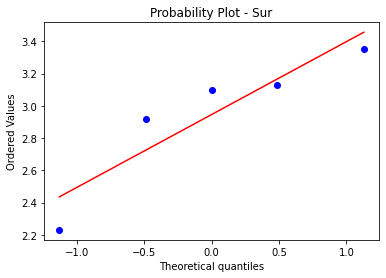

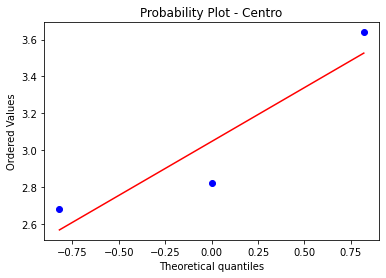

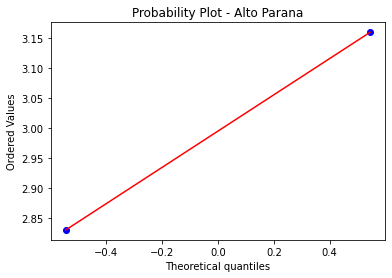

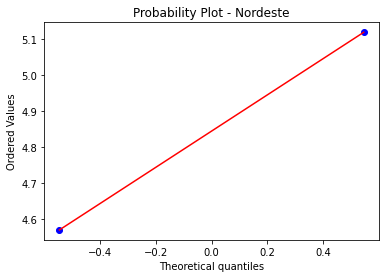

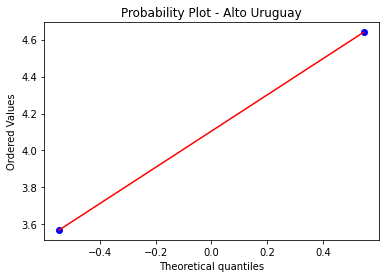

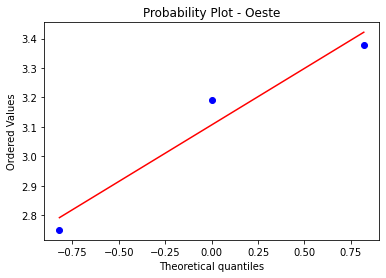

In [ ]:
from scipy import stats
# QQ Plot para analizar normalidad
unique_microrregiones = anova1['Microrregion'].unique()
for major in unique_microrregiones:
    stats.probplot(anova1[anova1['Microrregion'] == major]['NoLee x Depto'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  major)
    plt.show()

### Analisis varianza homogenea

In [ ]:
# calculate ratio of the largest to the smallest sample standard deviation
ratio = anova1.groupby('Microrregion').std().max() / anova1.groupby('Microrregion').std().min()
ratio

Lee               3.719396
NoLee x Depto     3.242424
TotalLee         27.018131
Poblacion        52.208018
dtype: float64

In [ ]:
medias = anova1.groupby('Microrregion')['NoLee x Depto'].mean()

### Modelo

In [ ]:
# H0 : todas las medias son iguales
# H1 : al menos una media difiere
# alpha : 0.05

anova1
groups = anova1.groupby('Microrregion').count().reset_index()
groups

# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = anova1['NoLee x Depto'].mean()
SSTR = anova1.groupby('Microrregion').count() * (anova1.groupby('Microrregion').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['NoLee x Depto'].sum()

# calculate SSE and update anova table
SSE = (anova1.groupby('Microrregion').count() - 1) * anova1.groupby('Microrregion').std()**2
anova_table['SS']['Within Groups'] = SSE['NoLee x Depto'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['NoLee x Depto'].sum() + SSE['NoLee x Depto'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = anova1['Microrregion'].nunique() - 1
anova_table['df']['Within Groups'] = anova1.shape[0] - anova1['Microrregion'].nunique()
anova_table['df']['Total'] = anova1.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

,SS,df,MS,F,P-value,F crit
Source of Variation,,,,,,
Between Groups,7.1309,5,1.42618,6.94465,0.00370221,4.044
Within Groups,2.259,11,0.205364,,,
Total,9.38991,16,0.586869,,,


### Resultado ANOVA

In [ ]:
# The p-value approach
print("Enfoque 1: utilizamos el p-value como regla de decisión")
conclusion = "No se puede rechazar la hipótesis nula."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Hipótesis nula rechazada."
print("F es:", anova_table['F']['Between Groups'], " y el p value es:", anova_table['P-value']['Between Groups'])    
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Enfoque 2: decisión en base al valor F")
conclusion = "No se puede rechazar la hipótesis nula."
if anova_table['F']['Between Groups'] > anova_table['F crit']['Between Groups']:
    conclusion = "Hipótesis nula rechazada."
print("F es:", anova_table['F']['Between Groups'], " y el valor crítico es:", anova_table['F crit']['Between Groups'])
print(conclusion)

Enfoque 1: utilizamos el p-value como regla de decisión
F es: 6.94464916290952  y el p value es: 0.0037022138417448502
Hipótesis nula rechazada.

--------------------------------------------------------------------------------------
Enfoque 2: decisión en base al valor F
F es: 6.94464916290952  y el valor crítico es: 4.04399822206869
Hipótesis nula rechazada.


## **Prueba t para dos muestras**

### Estructuración de datos

In [ ]:
analisis1['Poblacion'] = agro['TOTAL-Pob']
#analisis1['NoLee x Depto'] = analisis1['NoLee']/analisis1['Poblacion']*100

In [ ]:
analisis1

,Microrregion,Departamento,Lee,NoLee x Depto,TotalLee,Poblacion
0,Sur,Apóstoles,31.33,2.92,14470,42249
1,Centro,Cainguás,31.90,3.64,18981,53403
2,Sur,Candelaria,31.21,3.35,9346,27040
3,Sur,Capital,27.87,2.23,97740,324756
4,Sur,Concepción,32.59,3.13,3421,9577
5,Alto Parana,Eldorado,29.44,2.83,25360,78581
6,Nordeste,General Manuel Belgrano,33.18,4.57,16194,42902
7,Alto Uruguay,Guaraní,32.22,4.64,25027,67897
8,Alto Parana,Iguazú,30.23,3.16,27457,82227
9,Centro,Leandro N. Alem,29.11,2.68,14331,45075


In [ ]:
pruebat = analisis1[['Microrregion','NoLee x Depto']].sort_values(by='Microrregion')
pruebat

,Microrregion,NoLee x Depto
8,Alto Parana,3.16
5,Alto Parana,2.83
7,Alto Uruguay,4.64
16,Alto Uruguay,3.57
1,Centro,3.64
9,Centro,2.68
12,Centro,2.82
6,Nordeste,4.57
15,Nordeste,5.12
10,Oeste,3.19


In [ ]:
alto_parana = np.array(pruebat.iloc[:2])
alto_parana = np.delete(alto_parana, 0, axis=1)
alto_parana = np.array(alto_parana).tolist()

alto_uruguay = np.array(pruebat.iloc[2:4])
alto_uruguay = np.delete(alto_uruguay, 0, axis=1)
alto_uruguay = np.array(alto_uruguay).tolist()

centro = np.array(pruebat.iloc[4:7])
centro = np.delete(centro, 0, axis=1)
centro = np.array(centro).tolist()

nordeste = np.array(pruebat.iloc[7:9])
nordeste = np.delete(nordeste, 0, axis=1)
nordeste = np.array(nordeste).tolist()

oeste = np.array(pruebat.iloc[9:12])
oeste = np.delete(oeste, 0, axis=1)
oeste = np.array(oeste).tolist()

sur = np.array(pruebat.iloc[12:])
sur = np.delete(sur, 0, axis=1)
sur = np.array(sur).tolist()

In [ ]:
medias1 = [np.mean(alto_parana),np.mean(alto_uruguay),np.mean(centro),np.mean(nordeste),np.mean(oeste),np.mean(sur)]
medias1

[2.995,
 4.1049999999999995,
 3.046666666666667,
 4.845000000000001,
 3.106666666666667,
 2.946]

###Pruebas T

#### Alto Parana - Alto Uruguay

In [ ]:
# Testeamos varianza
print(np.var(alto_uruguay), np.var(alto_parana))

0.28622499999999995 0.027225000000000013


In [ ]:
if 0.28905272562086937 / 0.026501261276316385 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')


El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: alto_uruguay >= alto_parana
# H1: alto_uruguay < alto_parana
pruebat = stats.ttest_ind(alto_parana, alto_uruguay, equal_var=False)
pvalor1 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Alto Parana - Centro

In [ ]:
# Testeamos varianza
print(np.var(centro), np.var(alto_parana))

0.17928888888888894 0.027225000000000013


In [ ]:
if 0.17778854539776914  / 0.026501261276316385 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: centro >= alto_parana
# H1: centro < alto_parana
pruebat = stats.ttest_ind(alto_parana, centro, equal_var=False)
pvalor2 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Alto Parana - Nordeste

In [ ]:
# Testeamos varianza
print(np.var(nordeste), np.var(alto_parana))

0.07562499999999994 0.027225000000000013


In [ ]:
if 0.07773162891086295 / 0.026501261276316385 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: nordeste >= alto_parana
# H1: nordeste < alto_parana
pruebat = stats.ttest_ind(alto_parana, nordeste, equal_var=False)
pvalor3 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

Hay evidencia para rechazar H0


#### Alto Parana - Oeste

In [ ]:
# Testeamos varianza
print(np.var(oeste), np.var(alto_parana))

0.0696222222222222 0.027225000000000013


In [ ]:
if 0.06896955016988404 / 0.026501261276316385 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: oeste >= alto_parana
# H1: oeste < alto_parana
pruebat = stats.ttest_ind(alto_parana, oeste, equal_var=False)
pvalor4 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Alto Parana - Sur

In [ ]:
# Testeamos varianza
print(np.var(sur), np.var(alto_parana))

0.146824 0.027225000000000013


In [ ]:
if 0.14696477940164182 / 0.026501261276316385 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: sur >= alto_parana
# H1: sur < alto_parana
pruebat = stats.ttest_ind(alto_parana, sur, equal_var=False)
pvalor5 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Alto Uruguay - Centro

In [ ]:
# Testeamos varianza
print(np.var(centro), np.var(alto_uruguay))

0.17928888888888894 0.28622499999999995


In [ ]:
if 0.28905272562086937 / 0.17778854539776914 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

Las varianzas son similares, utilizar equal_var = True


In [ ]:
# H0: centro >= alto_uruguay
# H1: centro < alto_uruguay
pruebat = stats.ttest_ind(alto_uruguay, centro, equal_var=True)
pvalor6 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Alto Uruguay - Nordeste

In [ ]:
# Testeamos varianza
print(np.var(nordeste), np.var(alto_uruguay))

0.07562499999999994 0.28622499999999995


In [ ]:
if 0.28905272562086937 / 0.07773162891086295 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: nordeste >= alto_uruguay
# H1: nordeste < alto_uruguay
pruebat = stats.ttest_ind(alto_uruguay, nordeste, equal_var=False)
pvalor7 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Alto Uruguay - Oeste

In [ ]:
# Testeamos varianza
print(np.var(oeste), np.var(alto_uruguay))

0.0696222222222222 0.28622499999999995


In [ ]:
if 0.28905272562086937 / 0.06896955016988404 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: oeste >= alto_uruguay
# H1: oeste < alto_uruguay
pruebat = stats.ttest_ind(alto_uruguay, oeste, equal_var=False)
pvalor8 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Alto Uruguay - Sur

In [ ]:
# Testeamos varianza
print(np.var(sur), np.var(alto_uruguay))

0.146824 0.28622499999999995


In [ ]:
if 0.28905272562086937 / 0.14696477940164182 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

Las varianzas son similares, utilizar equal_var = True


In [ ]:
# H0: sur >= alto_uruguay
# H1: sur < alto_uruguay
pruebat = stats.ttest_ind(alto_uruguay, sur, equal_var=True)
pvalor9 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

Hay evidencia para rechazar H0


#### Centro - Nordeste

In [ ]:
# Testeamos varianza
print(np.var(nordeste), np.var(centro))

0.07562499999999994 0.17928888888888894


In [ ]:
if 0.17778854539776914 / 0.07773162891086295 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: nordeste >= centro
# H1: nordeste < centro
pruebat = stats.ttest_ind(centro, nordeste, equal_var=False)
pvalor10 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

Hay evidencia para rechazar H0


#### Centro - Oeste

In [ ]:
# Testeamos varianza
print(np.var(oeste), np.var(centro))

0.0696222222222222 0.17928888888888894


In [ ]:
if 0.17778854539776914 / 0.06896955016988404 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: oeste >= centro
# H1: oeste < centro
pruebat = stats.ttest_ind(centro, oeste, equal_var=False)
pvalor11 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Centro - Sur

In [ ]:
# Testeamos varianza
print(np.var(sur), np.var(centro))

0.146824 0.17928888888888894


In [ ]:
if 0.17778854539776914 / 0.14696477940164182 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

Las varianzas son similares, utilizar equal_var = True


In [ ]:
# H0: sur >= centro
# H1: sur < centro
pruebat = stats.ttest_ind(centro, sur, equal_var=True)
pvalor13 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


#### Nordeste - Oeste

In [ ]:
# Testeamos varianza
print(np.var(oeste), np.var(nordeste))

0.0696222222222222 0.07562499999999994


In [ ]:
if 0.07773162891086295 / 0.06896955016988404 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

Las varianzas son similares, utilizar equal_var = True


In [ ]:
# H0: oeste >= nordeste
# H1: oeste < nordeste
pruebat = stats.ttest_ind(nordeste, oeste, equal_var=True)
pvalor12 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

Hay evidencia para rechazar H0


#### Nordeste - Sur

In [ ]:
# Testeamos varianza
print(np.var(sur), np.var(nordeste))

0.146824 0.07562499999999994


In [ ]:
if 0.14696477940164182 / 0.07773162891086295 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

Las varianzas son similares, utilizar equal_var = True


In [ ]:
# H0: sur >= nordeste
# H1: sur < nordeste
pruebat = stats.ttest_ind(nordeste, sur, equal_var=True)
pvalor14 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

Hay evidencia para rechazar H0


#### Oeste - Sur

In [ ]:
# Testeamos varianza
print(np.var(sur), np.var(oeste))

0.146824 0.0696222222222222


In [ ]:
if 0.14696477940164182 / 0.06896955016988404 > 2:
  print('El ratio de las varianzas es mayor a 2, utilizar equal_var = False')
else:
  print('Las varianzas son similares, utilizar equal_var = True')

El ratio de las varianzas es mayor a 2, utilizar equal_var = False


In [ ]:
# H0: sur >= oeste
# H1: sur < oeste
pruebat = stats.ttest_ind(oeste, sur, equal_var=False)
pvalor15 = float(pruebat[1]/2)
if pruebat[1] / 2 > 0.05:
  print('No puedo rechazar H0')
else:
  print('Hay evidencia para rechazar H0')

No puedo rechazar H0


## Tabla P-Valores

In [ ]:
columnas = ['-','Alto Parana','Alto Uruguay','Centro','Nordeste','Oeste','Sur']
p_valores = pd.DataFrame([['Alto Parana','-',pvalor1,pvalor2,pvalor3,pvalor4,pvalor5],
                          ['Alto Uruguay',pvalor1,'-',pvalor6,pvalor7,pvalor8,pvalor9],
                          ['Centro',pvalor2,pvalor6,'-',pvalor10,pvalor11,pvalor13],
                          ['Nordeste',pvalor3,pvalor7,pvalor10,'-',pvalor12,pvalor14],
                          ['Oeste',pvalor4,pvalor8,pvalor11,pvalor12,'-',pvalor15],
                          ['Sur',pvalor5,pvalor9,pvalor13,pvalor14,pvalor15,'-']])
p_valores.columns = columnas
p_valores = p_valores.set_index('-')

In [ ]:
def color_pvalor(val):
    try:
      color = 'salmon' if val < 0.05 else 'white'
      return 'background-color: %s' % color
    except:
      pass

p_valores.style.applymap(color_pvalor)


,Alto Parana,Alto Uruguay,Centro,Nordeste,Oeste,Sur
-,,,,,,
Alto Parana,-,0.132667,0.444932,0.022252,0.342860,0.428137
Alto Uruguay,0.132667,-,0.076387,0.188873,0.144617,0.021141
Centro,0.444932,0.076387,-,0.012328,0.437356,0.387375
Nordeste,0.022252,0.188873,0.012328,-,0.005926,0.001478
Oeste,0.342860,0.144617,0.437356,0.005926,-,0.286101
Sur,0.428137,0.021141,0.387375,0.001478,0.286101,-
